In [0]:
import numpy as np
import _pickle as cPickle
import matplotlib.pyplot as plt
import torch
import helper
import torch.nn.functional as F
import matplotlib.image as img
import csv
import cv2
import os
import pandas as pd

from sklearn import metrics
from PIL import Image
from skimage import io, transform
from skimage.color import gray2rgb
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch import nn
from torch import optim
from torchsummary import summary
from torchvision import datasets, transforms, models, utils
from __future__ import print_function, division
from torch.utils.data import Dataset, DataLoader

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


# Loading The Dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
#cd gdrive/My Drive
!unzip "/content/gdrive/My Drive/MRNet-v1.0.zip"

## Data Loader Class

In [0]:
class MRNetDataset(Dataset):
    
    """ MRNet Dataset. """
    
    def __init__(self, csv_file_abnormal, csv_file_meniscus, csv_file_acl, 
                    root_dir, view, transform=None):
        
        """ Takes input the paths for the csv files and the root directory
        """
        
        self.labels_abnormal_csv = pd.read_csv(csv_file_abnormal, header=None)
        self.labels_meniscus_csv = pd.read_csv(csv_file_meniscus, header=None)
        self.labels_acl_csv = pd.read_csv(csv_file_acl, header=None)
        
        
        self.root_dir = root_dir
        self.axial_dir = os.path.join(self.root_dir, "axial")
        self.coronal_dir = os.path.join(self.root_dir, "coronal")
        self.sagittal_dir = os.path.join(self.root_dir, "sagittal")
        self.transform = transform
        self.perspective = view
        
        self.train_transforms = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])])
        
        
    def __len__(self):
        
        # all of them are of the same size so return the size of any of them
        return len(self.labels_abnormal_csv)
    
    
    def __getitem__(self, idx):
        
        #if the directory is valid then the idex starts from 1130, because we load by name
        if 'valid' in self.root_dir:
            idx = idx +1130
        
        
        examination_name_axial = os.path.join(self.axial_dir, '{:04d}'.format(idx) + ".npy")
        examination_name_coronal = os.path.join(self.coronal_dir, '{:04d}'.format(idx) + ".npy")
        examination_name_sagittal = os.path.join(self.sagittal_dir, '{:04d}'.format(idx) + ".npy")
        
        data = []
        
        if "coronal" in self.perspective:
            an_examination = np.load(examination_name_coronal, allow_pickle=True)
            
            for i in range(len(an_examination)):
                rgb = gray2rgb(an_examination[i])
                
                # resize image to 227*227*3
                img = Image.fromarray(rgb)
                basewidth = 224
                wpercent = (basewidth / float(img.size[0]))
                hsize = int((float(img.size[1]) * float(wpercent)))
                img = img.resize((basewidth, hsize), Image.ANTIALIAS)
                rgb = np.array(img)
                
                
                rgb = self.train_transforms(rgb)
                rgb = rgb.reshape(3,224,224)
                            
                data.append(rgb)
            
            
        elif "axial" in self.perspective:
            an_examination = np.load(examination_name_axial, allow_pickle=True)
            
            for i in range(len(an_examination)):
                rgb = gray2rgb(an_examination[i])
                            
                            
                # resize image to 227*227*3
                img = Image.fromarray(rgb)
                basewidth = 224
                wpercent = (basewidth / float(img.size[0]))
                hsize = int((float(img.size[1]) * float(wpercent)))
                img = img.resize((basewidth, hsize), Image.ANTIALIAS)
                rgb = np.array(img)
                
                
                rgb = self.train_transforms(rgb)
                rgb = rgb.reshape(3,224,224)            
                data.append(rgb)
            
              
        elif "sagittal" in self.perspective:
            an_examination = np.load(examination_name_sagittal, allow_pickle=True)
            
            for i in range(len(an_examination)):
                rgb = gray2rgb(an_examination[i])
                            
                # resize image to 227*227*3
                img = Image.fromarray(rgb)
                basewidth = 224
                wpercent = (basewidth / float(img.size[0]))
                hsize = int((float(img.size[1]) * float(wpercent)))
                img = img.resize((basewidth, hsize), Image.ANTIALIAS)
                rgb = np.array(img)            
                
                
                rgb = self.train_transforms(rgb)
                rgb = rgb.reshape(3,224,224)
                                         
                data.append(rgb)
            
        
        # if valid return idx -1130, because in labels we load by index
        if 'valid' in self.root_dir:
            idx = idx -1130
        
        its_acl_label = self.labels_acl_csv.iloc[idx, 1]
        its_meniscus_label = self.labels_meniscus_csv.iloc[idx, 1]
        its_abnormal_label = self.labels_abnormal_csv.iloc[idx, 1]
        """
        size_of_batch = len(an_examination)
        its_acl_label = np.full((size_of_batch), its_acl_label)
        its_meniscus_label = np.full((size_of_batch), its_meniscus_label)
        its_abnormal_label = np.full((size_of_batch), its_abnormal_label)
        
        
        #change to tensor
        its_acl_label = torch.from_numpy(its_acl_label)
        its_meniscus_label = torch.from_numpy(its_meniscus_label)
        its_abnormal_label = torch.from_numpy(its_abnormal_label)
        
        """
        
        its_acl_label = np.array([its_acl_label])
        its_meniscus_label = np.array([its_meniscus_label])
        its_abnormal_label = np.array([its_abnormal_label])
        #change to tensor
        its_acl_label = torch.from_numpy(its_acl_label)
        its_meniscus_label = torch.from_numpy(its_meniscus_label)
        its_abnormal_label = torch.from_numpy(its_abnormal_label)
        
        data = torch.stack(data)
        sample = {'examination': data, 'abnormal': its_abnormal_label, 
                    'meniscus': its_meniscus_label, 'acl': its_acl_label }
        

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
csv_file_abnormal_train_path = "/content/MRNet-v1.0/train-abnormal.csv"
csv_file_meniscus_train_path = "/content/MRNet-v1.0/train-meniscus.csv"
csv_file_acl_train_path = "/content/MRNet-v1.0/train-acl.csv"
train_root_dir = "/content/MRNet-v1.0/train"

csv_file_abnormal_valid_path = "/content/MRNet-v1.0/valid-abnormal.csv"
csv_file_meniscus_valid_path = "/content/MRNet-v1.0/valid-meniscus.csv"
csv_file_acl_valid_path = "/content/MRNet-v1.0/valid-acl.csv"
valid_root_dir = "/content/MRNet-v1.0/valid"

MRNet_train_coronal = MRNetDataset(csv_file_abnormal=csv_file_abnormal_train_path, 
                                csv_file_meniscus=csv_file_meniscus_train_path, 
                                csv_file_acl=csv_file_acl_train_path,
                                root_dir=train_root_dir,
                                view="coronal")
MRNet_valid_coronal = MRNetDataset(csv_file_abnormal=csv_file_abnormal_valid_path, 
                                csv_file_meniscus=csv_file_meniscus_valid_path, 
                                csv_file_acl=csv_file_acl_valid_path,
                                root_dir=valid_root_dir,
                                view="coronal")

print(MRNet_train_coronal[0]['examination'].shape)
print(MRNet_train_coronal[0]['acl'].shape)
print(MRNet_train_coronal[0]['abnormal'].shape)
print(MRNet_train_coronal[0]['meniscus'].shape)
print(len(MRNet_train_coronal))
print("---------------------------------------")
print(MRNet_valid_coronal[0]['examination'].shape)
print(MRNet_valid_coronal[0]['acl'].shape)
print(MRNet_valid_coronal[0]['abnormal'].shape)
print(MRNet_valid_coronal[0]['meniscus'].shape)
print(len(MRNet_valid_coronal))



torch.Size([36, 3, 224, 224])
torch.Size([1])
torch.Size([1])
torch.Size([1])
1130
---------------------------------------
torch.Size([25, 3, 224, 224])
torch.Size([1])
torch.Size([1])
torch.Size([1])
120


# Using the GPU if Available

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# A Sample of the Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


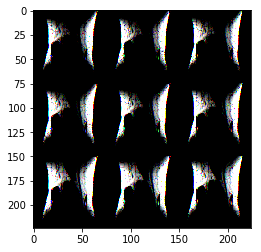

In [0]:
print(MRNet_train_coronal[0]['examination'][0].shape)
plt.imshow(MRNet_train_coronal[0]['examination'][0].reshape(224,224,3))
plt.show()

# The MRNet Model Using Pretrained AlexNet

In [0]:
# MRNet model
class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(nn.Linear(256, 256),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(256, 2))

    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        x = F.log_softmax(x)
        return x


# A Function to Train and Validate the Models

In [0]:
def train(epochs, mrnet_model, optimizer, criterion, scheduler, dataset_train, dataset_valid, label_name, file_name_to_save):
    running_loss = 0
    print_every = 1
    validate_loss_min = 999999
    train_losses, validate_losses, accuracies, f1_scores = [], [], [], []
    for epoch in range(epochs):
        running_loss = 0
        for i in range(len(dataset_train)):
            
            # Move input and label tensors to the default device
            sample = dataset_train[i]
            inputs, labels = sample['examination'], sample[label_name]

            inputs = inputs.float()
            labels = labels.long()

            inputs, labels = inputs.to(device), labels.to(device)



            logps = mrnet_model.forward(inputs)
            loss = criterion(logps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()



        else:
            test_loss = 0
            accuracy = 0
            correct = 0
            model_predictions, true_labels = [], []

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                mrnet_model.eval()
                for i in range(len(dataset_valid)):

                    sample = dataset_valid[i]
                    inputs, labels = sample['examination'], sample[label_name]

                    inputs = inputs.float()
                    labels = labels.long()

                    inputs, labels = inputs.to(device), labels.to(device)

                    logps = mrnet_model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                    a = top_class.cpu()
                    b = labels.cpu()
                    
                    a = a.data.item()
                    b = b.data.item()
                    
                    
                    model_predictions.append(a)
                    true_labels.append(b)



            mrnet_model.train()
            
            train_losses.append(running_loss/1130.0)
            validate_losses.append(test_loss/120.0)
            accuracies.append(accuracy/120.0)
            
            """
            true_labels = torch.stack(true_labels)
            model_predictions = torch.stack(model_predictions)
            
            true_labels = true_labels.numpy()
            model_predictions = model_predictions.numpy()
            """
            
            
            epoch_f1_score = metrics.f1_score(true_labels, model_predictions)
            f1_scores.append(epoch_f1_score)
            
            scheduler.step(validate_losses[-1])
            
            # save the model with the minimum validation loss
            if validate_losses[-1] <= validate_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                validate_loss_min, validate_losses[-1]))
                torch.save(mrnet_model.state_dict(), file_name_to_save)
                validate_loss_min = validate_losses[-1]
            
            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Validation Loss: {:.3f}.. ".format(validate_losses[-1]),
                  "Validation Accuracy: {:.3f}".format(accuracy/120.0),
                  "Validation F1-Score: {:.3f}".format(epoch_f1_score))
    return train_losses, validate_losses, accuracies, f1_scores            
            

# A Function to Evaluate an Ensemble of Models Detecting the Same Thing

This Function will take three instances of the model each trained on the axial, coronal, or sagittal exam dataset for detecting the presence of either acl tears, abnormalities, or meniscal tears and will decide the output as the maximum vote of the three models.

In [0]:
def ensumble_evaluation(criterion, model_axial, model_coronal, model_sagittal, dataset_axial, dataset_coronal, dataset_sagittal, label_name):
    
    test_loss_axial = 0
    test_loss_coronal = 0
    test_loss_sagittal = 0
    accuracy = 0
    correct = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model_axial.eval()
        model_coronal.eval()
        model_sagittal.eval()
        
        
        for i in range(len(dataset_valid)):
            
            class_0, class_1 = 0,0

            sample_axial = dataset_axial[i]
            sample_coronal = dataset_coronal[i]
            sample_sagittal = dataset_sagittal[i]
    
            inputs_axial, labels_axial = sample_axial['examination'], sample_axial[label_name]
            inputs_coronal, labels_coronal = sample_coronal['examination'], sample_coronal[label_name]
            inputs_sagittal, labels_sagittal = sample_sagittal['examination'], sample_sagittal[label_name]

            inputs_axial = inputs_axial.float()
            labels_axial = labels_axial.long()
    
            inputs_coronal = inputs_coronal.float()
            labels_coronal = labels_coronal.long()
    
            inputs_sagittal = inputs_sagittal.float()
            labels_sagittal = labels_sagittal.long()

            inputs_axial, labels_axial = inputs_axial.to(device), labels_axial.to(device)
            inputs_coronal, labels_coronal = inputs_coronal.to(device), labels_coronal.to(device)
            inputs_sagittal, labels_sagittal = inputs_sagittal.to(device), labels_sagittal.to(device)
    

            logps_axial = model_axial.forward(inputs_axial)
            batch_loss_axial = criterion(logps_axial, labels_axial)
            test_loss_axial += batch_loss_axial.item()
    
            logps_coronal = model_coronal.forward(inputs_coronal)
            batch_loss_coronal = criterion(logps_coronal, labels_coronal)
            test_loss_coronal += batch_loss_coronal.item()
    
            logps_sagittal = model_sagittal.forward(inputs_axial)
            batch_loss_sagittal = criterion(logps_sagittal, labels_sagittal)
            test_loss_sagittal += batch_loss_sagittal.item()

            # Calculate accuracy
            ps_axial = torch.exp(logps_axial)
            ps_coronal = torch.exp(logps_coronal)
            ps_sagittal = torch.exp(logps_sagittal)
    
            
            top_p_axial, top_class_axial = ps_axial.topk(1, dim=1)
            top_p_coronal, top_class_coronal = ps_coronal.topk(1, dim=1)
            top_p_sagittal, top_class_sagittal = ps_sagittal.topk(1, dim=1)
    
            # check how many model predicted 0 and 1
            if top_class_axial == 0:
                class_0 += 1
            else:
                class_1 += 1
    
            if top_class_coronal == 0:
                class_0 += 1
            else:
                class_1 += 1
    
            if top_class_sagittal == 0:
                class_0 += 1
            else:
                class_1 += 1
    
            # voting results
            if class_0 > class_1:
                top_class = 0
            else:
                top_class = 1
            
        
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        

        
        model_axial.train()
        model_coronal.train()
        model_sagittal.train()
          
        train_losses.append(running_loss/1130.0)
        validate_losses.append(test_loss/120.0)
        scheduler.step(validate_losses[-1])
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(validate_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/120.0))

# Creating the Datasets Used for Training the Models

In [0]:
#Coronal dataset
MRNet_train_coronal = MRNetDataset(csv_file_abnormal=csv_file_abnormal_train_path, 
                                csv_file_meniscus=csv_file_meniscus_train_path, 
                                csv_file_acl=csv_file_acl_train_path,
                                root_dir=train_root_dir,
                                view="coronal")
MRNet_valid_coronal = MRNetDataset(csv_file_abnormal=csv_file_abnormal_valid_path, 
                                csv_file_meniscus=csv_file_meniscus_valid_path, 
                                csv_file_acl=csv_file_acl_valid_path,
                                root_dir=valid_root_dir,
                                view="coronal")

#Axial dataset
MRNet_train_axial = MRNetDataset(csv_file_abnormal=csv_file_abnormal_train_path, 
                                csv_file_meniscus=csv_file_meniscus_train_path, 
                                csv_file_acl=csv_file_acl_train_path,
                                root_dir=train_root_dir,
                                view="axial")
MRNet_valid_axial = MRNetDataset(csv_file_abnormal=csv_file_abnormal_valid_path, 
                                csv_file_meniscus=csv_file_meniscus_valid_path, 
                                csv_file_acl=csv_file_acl_valid_path,
                                root_dir=valid_root_dir,
                                view="axial")

#Sagittal dataset
MRNet_train_sagittal = MRNetDataset(csv_file_abnormal=csv_file_abnormal_train_path, 
                                csv_file_meniscus=csv_file_meniscus_train_path, 
                                csv_file_acl=csv_file_acl_train_path,
                                root_dir=train_root_dir,
                                view="sagittal")
MRNet_valid_sagittal = MRNetDataset(csv_file_abnormal=csv_file_abnormal_valid_path, 
                                csv_file_meniscus=csv_file_meniscus_valid_path, 
                                csv_file_acl=csv_file_acl_valid_path,
                                root_dir=valid_root_dir,
                                view="sagittal")

# Creating and Training the Model

In [0]:
criterion = nn.NLLLoss()
epochs = [*range(1, 11)]

## Training the Model on Three Datasets for Detecting Abnormalities
One for the coronal exams dataset, one for the sagittal exam dataset, and one for the axial exam dataset.

In [0]:
# training the model with the axial exam dataset
mrnet_model_axial_abnormal = MRNet()
for param in mrnet_model_axial_abnormal.model.parameters():
    param.requires_grad = False
optimizer = optim.Adam(mrnet_model_axial_abnormal.classifier.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
mrnet_model_axial_abnormal.to(device)
train_losses, validate_losses, accuracies, f1_scores = train(10, mrnet_model_axial_abnormal, optimizer, criterion, 
                                                             scheduler, MRNet_train_axial, MRNet_valid_axial, 'abnormal', 'axial_abnormal.pt')




Validation loss decreased (999999.000000 --> 0.429347).  Saving model ...
Epoch: 1/10..  Training Loss: 0.786..  Validation Loss: 0.429..  Validation Accuracy: 0.817 Validation F1-Score: 0.889
Validation loss decreased (0.429347 --> 0.399423).  Saving model ...
Epoch: 2/10..  Training Loss: 0.594..  Validation Loss: 0.399..  Validation Accuracy: 0.833 Validation F1-Score: 0.901
Validation loss decreased (0.399423 --> 0.386147).  Saving model ...
Epoch: 3/10..  Training Loss: 0.621..  Validation Loss: 0.386..  Validation Accuracy: 0.858 Validation F1-Score: 0.917
Epoch: 4/10..  Training Loss: 0.562..  Validation Loss: 0.393..  Validation Accuracy: 0.825 Validation F1-Score: 0.900
Epoch: 5/10..  Training Loss: 0.596..  Validation Loss: 0.508..  Validation Accuracy: 0.758 Validation F1-Score: 0.832
Validation loss decreased (0.386147 --> 0.373049).  Saving model ...
Epoch: 6/10..  Training Loss: 0.564..  Validation Loss: 0.373..  Validation Accuracy: 0.842 Validation F1-Score: 0.906
Epoch

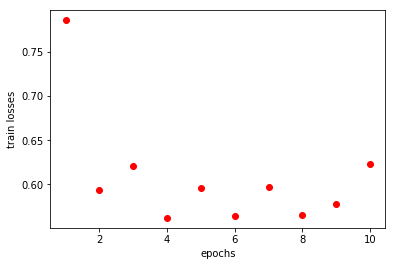

In [0]:
plt.plot(epochs, train_losses, 'ro')
plt.ylabel('train losses')
plt.xlabel('epochs')
plt.show()

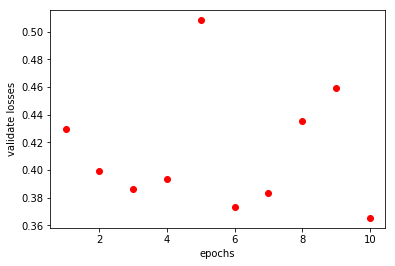

In [0]:
plt.plot(epochs, validate_losses, 'ro')
plt.ylabel('validate losses')
plt.xlabel('epochs')
plt.show()

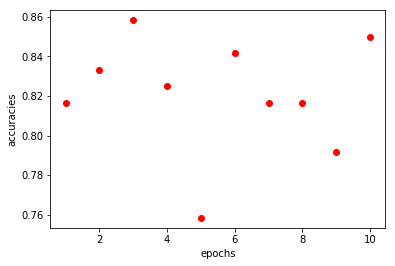

In [0]:
plt.plot(epochs, accuracies, 'ro')
plt.ylabel('accuracies')
plt.xlabel('epochs')
plt.show()

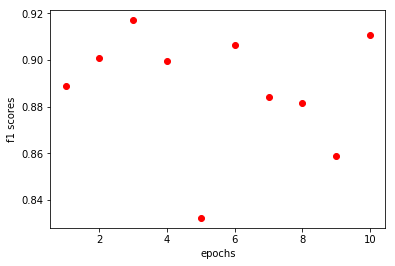

In [0]:
plt.plot(epochs, f1_scores, 'ro')
plt.ylabel('f1 scores')
plt.xlabel('epochs')
plt.show()

In [0]:
# training the model with the coronal exam dataset
mrnet_model_coronal_abnormal = MRNet()
for param in mrnet_model_coronal_abnormal.model.parameters():
    param.requires_grad = False
optimizer = optim.Adam(mrnet_model_coronal_abnormal.classifier.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
mrnet_model_coronal_abnormal.to(device)
train_losses, validate_losses, accuracies, f1_scores = train(10, mrnet_model_coronal_abnormal, optimizer, criterion, 
                                                             scheduler, MRNet_train_coronal, MRNet_valid_coronal, 'abnormal', 'coronal_abnormal.pt')



Validation loss decreased (999999.000000 --> 0.497068).  Saving model ...
Epoch: 1/10..  Training Loss: 0.755..  Validation Loss: 0.497..  Validation Accuracy: 0.775 Validation F1-Score: 0.862
Epoch: 2/10..  Training Loss: 0.587..  Validation Loss: 0.501..  Validation Accuracy: 0.742 Validation F1-Score: 0.832
Validation loss decreased (0.497068 --> 0.485285).  Saving model ...
Epoch: 3/10..  Training Loss: 0.597..  Validation Loss: 0.485..  Validation Accuracy: 0.783 Validation F1-Score: 0.865
Epoch: 4/10..  Training Loss: 0.596..  Validation Loss: 0.576..  Validation Accuracy: 0.708 Validation F1-Score: 0.800
Epoch: 5/10..  Training Loss: 0.599..  Validation Loss: 0.532..  Validation Accuracy: 0.817 Validation F1-Score: 0.888
Epoch: 6/10..  Training Loss: 0.628..  Validation Loss: 0.511..  Validation Accuracy: 0.758 Validation F1-Score: 0.843
Validation loss decreased (0.485285 --> 0.476579).  Saving model ...
Epoch: 7/10..  Training Loss: 0.533..  Validation Loss: 0.477..  Validatio

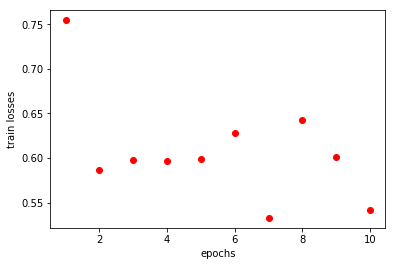

In [0]:
plt.plot(epochs, train_losses, 'ro')
plt.ylabel('train losses')
plt.xlabel('epochs')
plt.show()

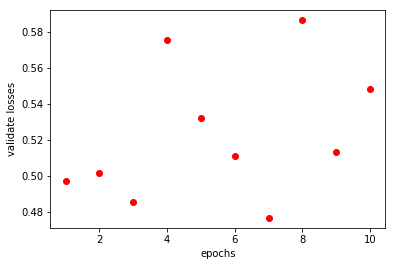

In [0]:
plt.plot(epochs, validate_losses, 'ro')
plt.ylabel('validate losses')
plt.xlabel('epochs')
plt.show()

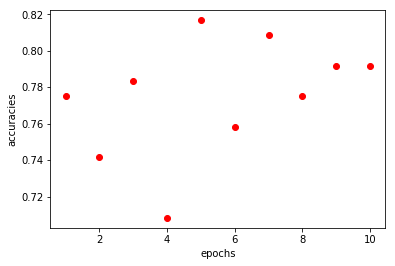

In [0]:
plt.plot(epochs, accuracies, 'ro')
plt.ylabel('accuracies')
plt.xlabel('epochs')
plt.show()

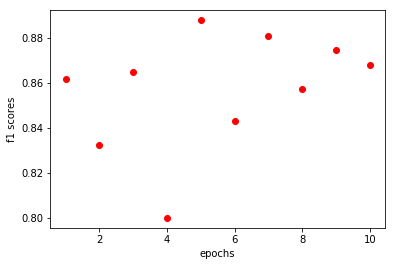

In [0]:
plt.plot(epochs, f1_scores, 'ro')
plt.ylabel('f1 scores')
plt.xlabel('epochs')
plt.show()

In [0]:
# training the model with the sagittal exam dataset
mrnet_model_sagittal_abnormal = MRNet()
for param in mrnet_model_sagittal_abnormal.model.parameters():
    param.requires_grad = False
optimizer = optim.Adam(mrnet_model_sagittal_abnormal.classifier.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
mrnet_model_sagittal_abnormal.to(device)
train_losses, validate_losses, accuracies, f1_scores = train(10, mrnet_model_sagittal_abnormal, optimizer, criterion, 
                                                             scheduler, MRNet_train_sagittal, MRNet_valid_sagittal, 'abnormal', 'sagittal_abnormal.pt')



Validation loss decreased (999999.000000 --> 0.365848).  Saving model ...
Epoch: 1/10..  Training Loss: 0.724..  Validation Loss: 0.366..  Validation Accuracy: 0.875 Validation F1-Score: 0.925
Validation loss decreased (0.365848 --> 0.318910).  Saving model ...
Epoch: 2/10..  Training Loss: 0.584..  Validation Loss: 0.319..  Validation Accuracy: 0.858 Validation F1-Score: 0.917
Epoch: 3/10..  Training Loss: 0.565..  Validation Loss: 0.473..  Validation Accuracy: 0.792 Validation F1-Score: 0.848
Validation loss decreased (0.318910 --> 0.305466).  Saving model ...
Epoch: 4/10..  Training Loss: 0.585..  Validation Loss: 0.305..  Validation Accuracy: 0.875 Validation F1-Score: 0.925
Validation loss decreased (0.305466 --> 0.272454).  Saving model ...
Epoch: 5/10..  Training Loss: 0.560..  Validation Loss: 0.272..  Validation Accuracy: 0.892 Validation F1-Score: 0.936
Epoch: 6/10..  Training Loss: 0.514..  Validation Loss: 0.400..  Validation Accuracy: 0.833 Validation F1-Score: 0.885
Epoch

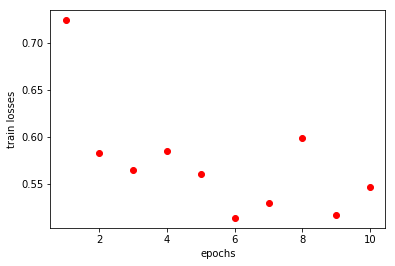

In [0]:
plt.plot(epochs, train_losses, 'ro')
plt.ylabel('train losses')
plt.xlabel('epochs')
plt.show()

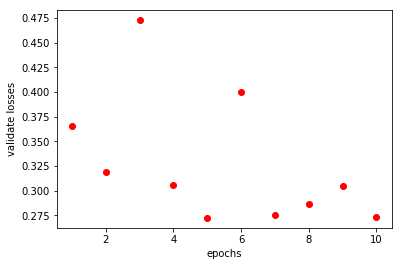

In [0]:
plt.plot(epochs, validate_losses, 'ro')
plt.ylabel('validate losses')
plt.xlabel('epochs')
plt.show()

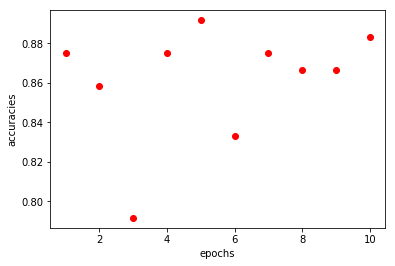

In [0]:
plt.plot(epochs, accuracies, 'ro')
plt.ylabel('accuracies')
plt.xlabel('epochs')
plt.show()

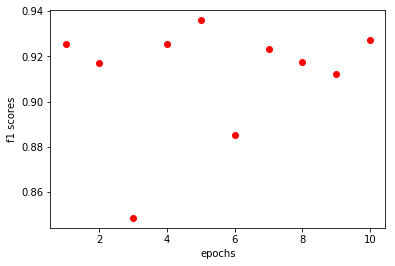

In [0]:
plt.plot(epochs, f1_scores, 'ro')
plt.ylabel('f1 scores')
plt.xlabel('epochs')
plt.show()

## Training the Model on Three Datasets for Detecting ACL Tears
One for the coronal exams dataset, one for the sagittal exam dataset, and one for the axial exam dataset.

In [0]:
# training the model with the axial exam dataset
mrnet_model_axial_acl = MRNet()
for param in mrnet_model_axial_acl.model.parameters():
    param.requires_grad = False
optimizer = optim.Adam(mrnet_model_axial_acl.classifier.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
mrnet_model_axial_acl.to(device)
train_losses, validate_losses, accuracies, f1_scores = train(10, mrnet_model_axial_acl, optimizer, criterion, 
                                                             scheduler, MRNet_train_axial, MRNet_valid_axial, 'acl', 'axial_acl.pt')



Validation loss decreased (999999.000000 --> 1.066770).  Saving model ...
Epoch: 1/10..  Training Loss: 0.900..  Validation Loss: 1.067..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Epoch: 2/10..  Training Loss: 0.595..  Validation Loss: 1.548..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Validation loss decreased (1.066770 --> 1.012847).  Saving model ...
Epoch: 3/10..  Training Loss: 0.656..  Validation Loss: 1.013..  Validation Accuracy: 0.558 Validation F1-Score: 0.036
Epoch: 4/10..  Training Loss: 0.649..  Validation Loss: 1.221..  Validation Accuracy: 0.558 Validation F1-Score: 0.036
Epoch: 5/10..  Training Loss: 0.645..  Validation Loss: 1.274..  Validation Accuracy: 0.558 Validation F1-Score: 0.036
Epoch: 6/10..  Training Loss: 0.583..  Validation Loss: 1.106..  Validation Accuracy: 0.558 Validation F1-Score: 0.036
Epoch: 7/10..  Training Loss: 0.612..  Validation Loss: 1.021..  Validation Accuracy: 0.592 Validation F1-Score: 0.169
Epoch: 8/10..  Training 

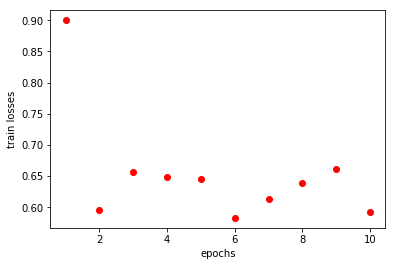

In [0]:
plt.plot(epochs, train_losses, 'ro')
plt.ylabel('train losses')
plt.xlabel('epochs')
plt.show()

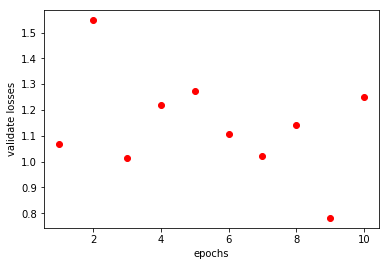

In [0]:
plt.plot(epochs, validate_losses, 'ro')
plt.ylabel('validate losses')
plt.xlabel('epochs')
plt.show()

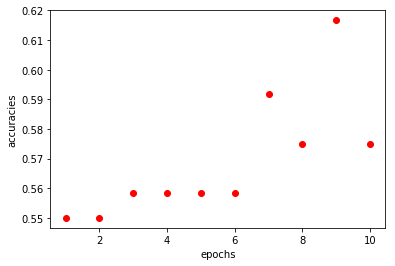

In [0]:
plt.plot(epochs, accuracies, 'ro')
plt.ylabel('accuracies')
plt.xlabel('epochs')
plt.show()

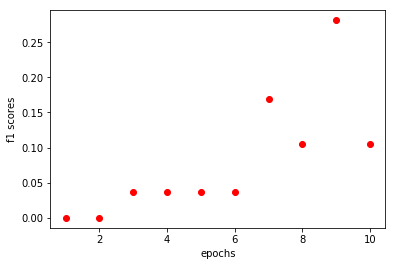

In [0]:
plt.plot(epochs, f1_scores, 'ro')
plt.ylabel('f1 scores')
plt.xlabel('epochs')
plt.show()

In [0]:
# training the model with the coronal exam dataset
mrnet_model_coronal_acl = MRNet()
for param in mrnet_model_coronal_acl.model.parameters():
    param.requires_grad = False
optimizer = optim.Adam(mrnet_model_coronal_acl.classifier.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
mrnet_model_coronal_acl.to(device)
train_losses, validate_losses, accuracies, f1_scores = train(10, mrnet_model_coronal_acl, optimizer, criterion, 
                                                             scheduler, MRNet_train_coronal, MRNet_valid_coronal, 'acl', 'coronal_acl.pt')


Validation loss decreased (999999.000000 --> 1.151996).  Saving model ...
Epoch: 1/10..  Training Loss: 0.980..  Validation Loss: 1.152..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Epoch: 2/10..  Training Loss: 0.601..  Validation Loss: 1.252..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Epoch: 3/10..  Training Loss: 0.604..  Validation Loss: 2.187..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Epoch: 4/10..  Training Loss: 0.661..  Validation Loss: 1.826..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Validation loss decreased (1.151996 --> 1.090055).  Saving model ...
Epoch: 5/10..  Training Loss: 0.622..  Validation Loss: 1.090..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Epoch: 6/10..  Training Loss: 0.637..  Validation Loss: 1.580..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Validation loss decreased (1.090055 --> 1.006934).  Saving model ...
Epoch: 7/10..  Training Loss: 0.648..  Validation Loss: 1.007..  Validatio

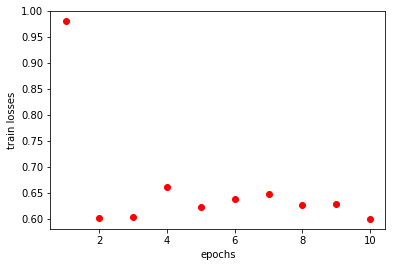

In [0]:
plt.plot(epochs, train_losses, 'ro')
plt.ylabel('train losses')
plt.xlabel('epochs')
plt.show()

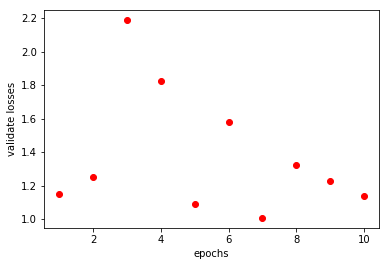

In [0]:
plt.plot(epochs, validate_losses, 'ro')
plt.ylabel('validate losses')
plt.xlabel('epochs')
plt.show()

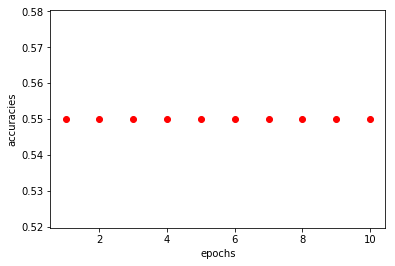

In [0]:
plt.plot(epochs, accuracies, 'ro')
plt.ylabel('accuracies')
plt.xlabel('epochs')
plt.show()

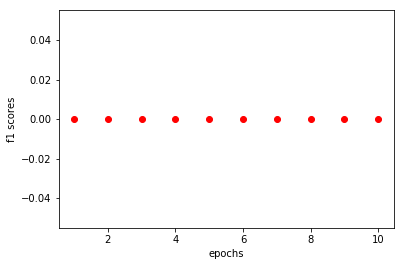

In [0]:
plt.plot(epochs, f1_scores, 'ro')
plt.ylabel('f1 scores')
plt.xlabel('epochs')
plt.show()

In [0]:
# training the model with the sagittal exam dataset
mrnet_model_sagittal_acl = MRNet()
for param in mrnet_model_sagittal_acl.model.parameters():
    param.requires_grad = False
optimizer = optim.Adam(mrnet_model_sagittal_acl.classifier.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
mrnet_model_sagittal_acl.to(device)
train_losses, validate_losses, accuracies, f1_scores = train(10, mrnet_model_sagittal_acl, optimizer, criterion, 
                                                             scheduler, MRNet_train_sagittal, MRNet_valid_sagittal, 'acl', 'sagittal_acl.pt')



Validation loss decreased (999999.000000 --> 1.194997).  Saving model ...
Epoch: 1/10..  Training Loss: 0.845..  Validation Loss: 1.195..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Epoch: 2/10..  Training Loss: 0.557..  Validation Loss: 1.438..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Epoch: 3/10..  Training Loss: 0.617..  Validation Loss: 1.200..  Validation Accuracy: 0.567 Validation F1-Score: 0.071
Epoch: 4/10..  Training Loss: 0.592..  Validation Loss: 1.469..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Epoch: 5/10..  Training Loss: 0.591..  Validation Loss: 1.288..  Validation Accuracy: 0.550 Validation F1-Score: 0.000
Epoch: 6/10..  Training Loss: 0.593..  Validation Loss: 1.274..  Validation Accuracy: 0.567 Validation F1-Score: 0.071
Epoch: 7/10..  Training Loss: 0.558..  Validation Loss: 1.338..  Validation Accuracy: 0.567 Validation F1-Score: 0.071
Epoch: 8/10..  Training Loss: 0.569..  Validation Loss: 1.721..  Validation Accuracy: 0.550 V

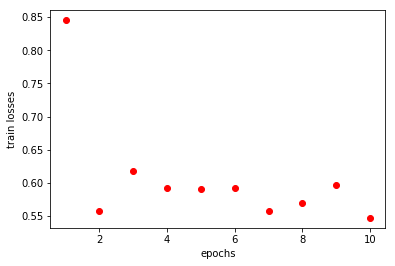

In [0]:
plt.plot(epochs, train_losses, 'ro')
plt.ylabel('train losses')
plt.xlabel('epochs')
plt.show()

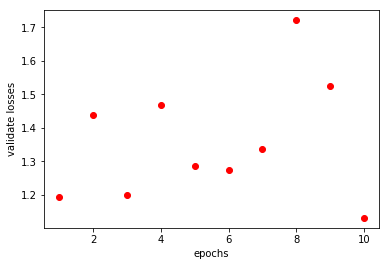

In [0]:
plt.plot(epochs, validate_losses, 'ro')
plt.ylabel('validate losses')
plt.xlabel('epochs')
plt.show()

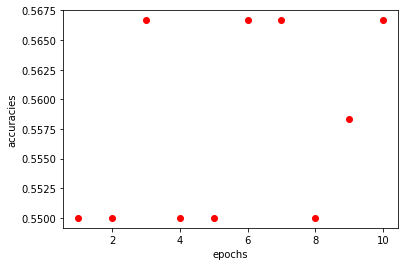

In [0]:
plt.plot(epochs, accuracies, 'ro')
plt.ylabel('accuracies')
plt.xlabel('epochs')
plt.show()

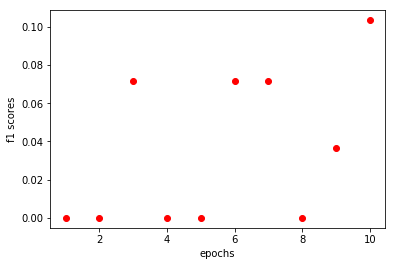

In [0]:
plt.plot(epochs, f1_scores, 'ro')
plt.ylabel('f1 scores')
plt.xlabel('epochs')
plt.show()

## Training the Model on Three Datasets for Detecting Meniscal Tears
One for the coronal exams dataset, one for the sagittal exam dataset, and one for the axial exam dataset.

In [0]:
# training the model with the axial exam dataset
mrnet_model_axial_meniscus = MRNet()
for param in mrnet_model_axial_meniscus.model.parameters():
    param.requires_grad = False
optimizer = optim.Adam(mrnet_model_axial_meniscus.classifier.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
mrnet_model_axial_meniscus.to(device)
train_losses, validate_losses, accuracies, f1_scores = train(10, mrnet_model_axial_meniscus, optimizer, criterion, 
                                                             scheduler, MRNet_train_axial, MRNet_valid_axial, 'meniscus', 'axial_meniscus.pt')


Validation loss decreased (999999.000000 --> 0.831929).  Saving model ...
Epoch: 1/10..  Training Loss: 1.044..  Validation Loss: 0.832..  Validation Accuracy: 0.567 Validation F1-Score: 0.000
Validation loss decreased (0.831929 --> 0.744761).  Saving model ...
Epoch: 2/10..  Training Loss: 0.753..  Validation Loss: 0.745..  Validation Accuracy: 0.550 Validation F1-Score: 0.036
Validation loss decreased (0.744761 --> 0.732913).  Saving model ...
Epoch: 3/10..  Training Loss: 0.756..  Validation Loss: 0.733..  Validation Accuracy: 0.550 Validation F1-Score: 0.069
Epoch: 4/10..  Training Loss: 0.782..  Validation Loss: 1.119..  Validation Accuracy: 0.567 Validation F1-Score: 0.000
Epoch: 5/10..  Training Loss: 0.778..  Validation Loss: 0.896..  Validation Accuracy: 0.542 Validation F1-Score: 0.000
Epoch: 6/10..  Training Loss: 0.780..  Validation Loss: 0.938..  Validation Accuracy: 0.558 Validation F1-Score: 0.036
Epoch: 7/10..  Training Loss: 0.804..  Validation Loss: 0.882..  Validatio

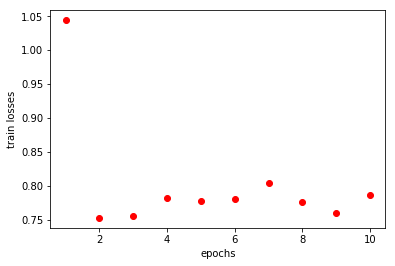

In [0]:
plt.plot(epochs, train_losses, 'ro')
plt.ylabel('train losses')
plt.xlabel('epochs')
plt.show()

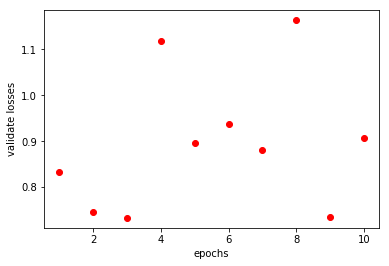

In [0]:
plt.plot(epochs, validate_losses, 'ro')
plt.ylabel('validate losses')
plt.xlabel('epochs')
plt.show()

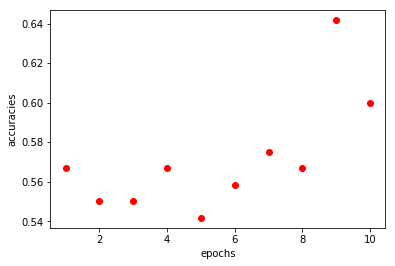

In [0]:
plt.plot(epochs, accuracies, 'ro')
plt.ylabel('accuracies')
plt.xlabel('epochs')
plt.show()

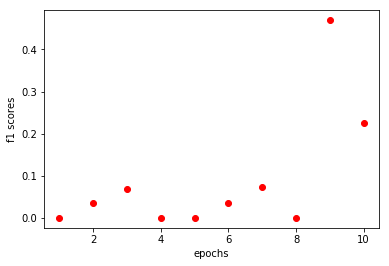

In [0]:
plt.plot(epochs, f1_scores, 'ro')
plt.ylabel('f1 scores')
plt.xlabel('epochs')
plt.show()

In [0]:
# training the model with the coronal exam dataset
mrnet_model_coronal_meniscus = MRNet()
for param in mrnet_model_coronal_meniscus.model.parameters():
    param.requires_grad = False
optimizer = optim.Adam(mrnet_model_coronal_meniscus.classifier.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
mrnet_model_coronal_meniscus.to(device)
train_losses, validate_losses, accuracies, f1_scores = train(10, mrnet_model_coronal_meniscus, optimizer, criterion, 
                                                             scheduler, MRNet_train_coronal, MRNet_valid_coronal, 'meniscus', 'coronal_meniscus.pt')



Validation loss decreased (999999.000000 --> 0.715655).  Saving model ...
Epoch: 1/10..  Training Loss: 0.985..  Validation Loss: 0.716..  Validation Accuracy: 0.583 Validation F1-Score: 0.074
Epoch: 2/10..  Training Loss: 0.770..  Validation Loss: 0.998..  Validation Accuracy: 0.575 Validation F1-Score: 0.038
Epoch: 3/10..  Training Loss: 0.770..  Validation Loss: 0.959..  Validation Accuracy: 0.575 Validation F1-Score: 0.038
Epoch: 4/10..  Training Loss: 0.765..  Validation Loss: 0.754..  Validation Accuracy: 0.592 Validation F1-Score: 0.109
Epoch: 5/10..  Training Loss: 0.777..  Validation Loss: 0.970..  Validation Accuracy: 0.575 Validation F1-Score: 0.038
Epoch: 6/10..  Training Loss: 0.767..  Validation Loss: 0.768..  Validation Accuracy: 0.583 Validation F1-Score: 0.107
Validation loss decreased (0.715655 --> 0.666602).  Saving model ...
Epoch: 7/10..  Training Loss: 0.786..  Validation Loss: 0.667..  Validation Accuracy: 0.658 Validation F1-Score: 0.369
Epoch: 8/10..  Training 

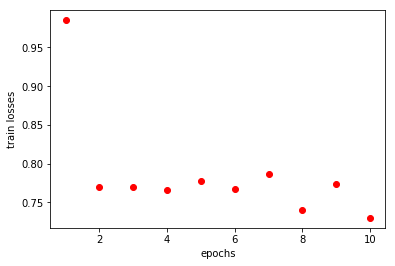

In [0]:
plt.plot(epochs, train_losses, 'ro')
plt.ylabel('train losses')
plt.xlabel('epochs')
plt.show()

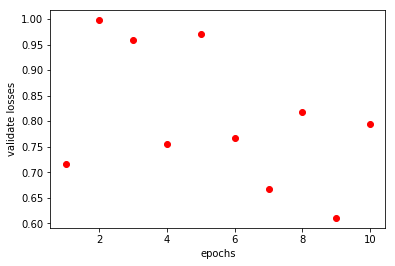

In [0]:
plt.plot(epochs, validate_losses, 'ro')
plt.ylabel('validate losses')
plt.xlabel('epochs')
plt.show()

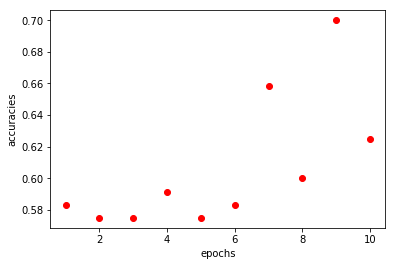

In [0]:
plt.plot(epochs, accuracies, 'ro')
plt.ylabel('accuracies')
plt.xlabel('epochs')
plt.show()

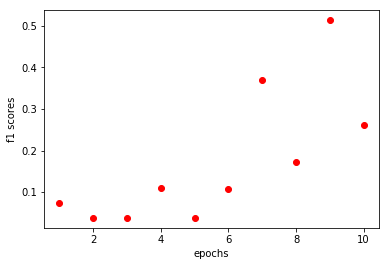

In [0]:
plt.plot(epochs, f1_scores, 'ro')
plt.ylabel('f1 scores')
plt.xlabel('epochs')
plt.show()

In [0]:
# training the model with the sagittal exam dataset
mrnet_model_sagittal_meniscus = MRNet()
for param in mrnet_model_sagittal_meniscus.model.parameters():
    param.requires_grad = False
optimizer = optim.Adam(mrnet_model_sagittal_meniscus.classifier.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
mrnet_model_sagittal_meniscus.to(device)
train_losses, validate_losses, accuracies, f1_scores = train(10, mrnet_model_sagittal_meniscus, optimizer, criterion, 
                                                             scheduler, MRNet_train_sagittal, MRNet_valid_sagittal, 'meniscus', 'sagittal_meniscus.pt')


Validation loss decreased (999999.000000 --> 0.806733).  Saving model ...
Epoch: 1/10..  Training Loss: 1.006..  Validation Loss: 0.807..  Validation Accuracy: 0.575 Validation F1-Score: 0.038
Validation loss decreased (0.806733 --> 0.744928).  Saving model ...
Epoch: 2/10..  Training Loss: 0.726..  Validation Loss: 0.745..  Validation Accuracy: 0.575 Validation F1-Score: 0.038
Epoch: 3/10..  Training Loss: 0.755..  Validation Loss: 0.821..  Validation Accuracy: 0.583 Validation F1-Score: 0.074
Validation loss decreased (0.744928 --> 0.595023).  Saving model ...
Epoch: 4/10..  Training Loss: 0.756..  Validation Loss: 0.595..  Validation Accuracy: 0.667 Validation F1-Score: 0.556
Epoch: 5/10..  Training Loss: 0.759..  Validation Loss: 0.861..  Validation Accuracy: 0.600 Validation F1-Score: 0.143
Epoch: 6/10..  Training Loss: 0.761..  Validation Loss: 0.697..  Validation Accuracy: 0.650 Validation F1-Score: 0.323
Epoch: 7/10..  Training Loss: 0.748..  Validation Loss: 0.621..  Validatio

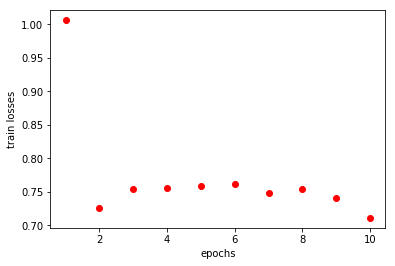

In [0]:
plt.plot(epochs, train_losses, 'ro')
plt.ylabel('train losses')
plt.xlabel('epochs')
plt.show()

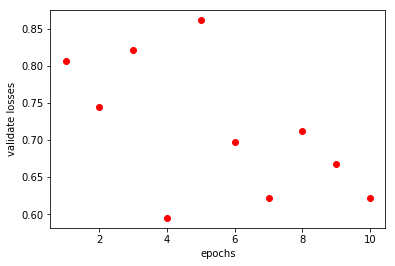

In [0]:
plt.plot(epochs, validate_losses, 'ro')
plt.ylabel('validate losses')
plt.xlabel('epochs')
plt.show()

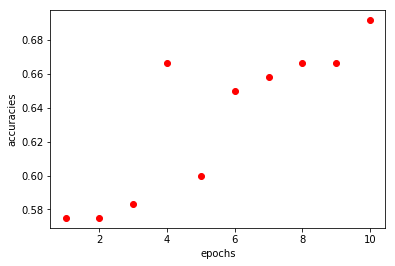

In [0]:
plt.plot(epochs, accuracies, 'ro')
plt.ylabel('accuracies')
plt.xlabel('epochs')
plt.show()

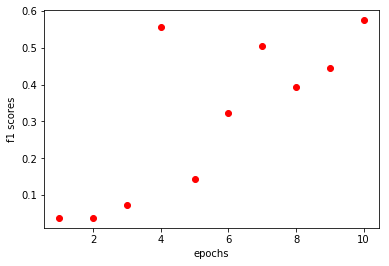

In [0]:
plt.plot(epochs, f1_scores, 'ro')
plt.ylabel('f1 scores')
plt.xlabel('epochs')
plt.show()

In [0]:
!cp axial_abnormal.pt axial_acl.pt axial_meniscus.pt coronal_abnormal.pt coronal_acl.pt coronal_meniscus.pt sagittal_abnormal.pt sagittal_acl.pt sagittal_meniscus.pt "/content/gdrive/My Drive/MR-NET" 